In [ ]:
from datetime import datetime, timedelta
from matplotlib import pyplot
from matplotlib.pylab import rcParams
from pandas import DataFrame
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, explained_variance_score, mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error, make_scorer
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from statistics import mean
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from time import sleep
from tqdm import tqdm, tqdm_notebook
from tqdm.notebook import trange, tqdm, tnrange
from IPython.display import clear_output
from sklearn.model_selection import TimeSeriesSplit
from google.colab import drive
import statsmodels.api as sm
import statsmodels.formula.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import normal_ad
from sklearn.model_selection import TimeSeriesSplit
import datetime as dt
import getpass
import graphviz
import hyperopt
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import pycountry
import pycountry_convert as pc
import pydotplus
import seaborn as sns
import sklearn.linear_model as lm
import statsmodels.api as sm
import warnings
from sklearn import preprocessing
pd.options.display.float_format = '{:.2f}'.format   
pd.plotting.register_matplotlib_converters()
rcParams['figure.figsize'] = 15, 5
warnings.filterwarnings('ignore')

## Data load

In [ ]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
df = pd.read_csv(url)
df = pd.melt(df, id_vars=['Province/State', 'Country/Region','Lat','Long'], var_name='Date', value_name='Confirmed')
df['Date'] = pd.to_datetime(df['Date'])
df.head(5)

,Province/State,Country/Region,Lat,Long,Date,Confirmed
0,NaN,Afghanistan,33.94,67.71,2020-01-22,0
1,NaN,Albania,41.15,20.17,2020-01-22,0
2,NaN,Algeria,28.03,1.66,2020-01-22,0
3,NaN,Andorra,42.51,1.52,2020-01-22,0
4,NaN,Angola,-11.20,17.87,2020-01-22,0


In [ ]:
max(df.Date)

Timestamp('2020-11-25 00:00:00')

In [ ]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83739 entries, 0 to 83738
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Province/State  25647 non-null  object        
 1   Country/Region  83739 non-null  object        
 2   Lat             83430 non-null  float64       
 3   Long            83430 non-null  float64       
 4   Date            83739 non-null  datetime64[ns]
 5   Confirmed       83739 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 3.8+ MB


In [ ]:
df = df.rename(columns={'Province/State': 'Province', 'Country/Region': 'Country'})
df.shape

(83739, 6)

In [ ]:
df_worldwide = pd.DataFrame(df.groupby('Date')['Confirmed'].sum())
df_worldwide['Date'] = df_worldwide.index
df_worldwide = df_worldwide.reset_index(drop=True)
df_worldwide['Country'] = 'Worldwide'
df = df.append(df_worldwide)

In [ ]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv'
df_country = pd.read_csv(url)
df_country = df_country.drop_duplicates(subset=['Country_Region'], keep='first')
df_country

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Population
0,4,AF,AFG,4.00,nan,NaN,NaN,Afghanistan,33.94,67.71,Afghanistan,38928341.00
1,8,AL,ALB,8.00,nan,NaN,NaN,Albania,41.15,20.17,Albania,2877800.00
2,12,DZ,DZA,12.00,nan,NaN,NaN,Algeria,28.03,1.66,Algeria,43851043.00
3,20,AD,AND,20.00,nan,NaN,NaN,Andorra,42.51,1.52,Andorra,77265.00
4,24,AO,AGO,24.00,nan,NaN,NaN,Angola,-11.20,17.87,Angola,32866268.00
...,...,...,...,...,...,...,...,...,...,...,...,...
705,716,ZW,ZWE,716.00,nan,NaN,NaN,Zimbabwe,-19.02,29.15,Zimbabwe,14862927.00
706,36,AU,AUS,36.00,nan,NaN,NaN,Australia,-25.00,133.00,Australia,25459700.00
715,124,CA,CAN,124.00,nan,NaN,NaN,Canada,60.00,-95.00,Canada,37855702.00
732,156,CN,CHN,156.00,nan,NaN,NaN,China,30.59,114.31,China,1404676330.00


In [ ]:
# apply the mapping to df
df = pd.merge(df, df_country[['Country_Region','iso2']], left_on='Country', right_on='Country_Region', how='left')
df

,Province,Country,Lat,Long,Date,Confirmed,Country_Region,iso2
0,NaN,Afghanistan,33.94,67.71,2020-01-22,0,Afghanistan,AF
1,NaN,Albania,41.15,20.17,2020-01-22,0,Albania,AL
2,NaN,Algeria,28.03,1.66,2020-01-22,0,Algeria,DZ
3,NaN,Andorra,42.51,1.52,2020-01-22,0,Andorra,AD
4,NaN,Angola,-11.20,17.87,2020-01-22,0,Angola,AO
...,...,...,...,...,...,...,...,...
84043,NaN,Worldwide,nan,nan,2020-11-21,58165570,NaN,NaN
84044,NaN,Worldwide,nan,nan,2020-11-22,58649369,NaN,NaN
84045,NaN,Worldwide,nan,nan,2020-11-23,59171078,NaN,NaN
84046,NaN,Worldwide,nan,nan,2020-11-24,59759494,NaN,NaN


In [ ]:
def alpha2_to_continent(iso):
    try: cont = pc.country_alpha2_to_continent_code(iso)
    except: cont = float('NaN')
    return cont

df['Continent'] = df['iso2'].apply(alpha2_to_continent) # get continent code

df.loc[df['Country'] == "Diamond Princess", 'Continent'] = "Diamond Princess"
df.loc[df['Country'] == "MS Zaandam", 'Continent'] = "MS Zaandam"
df.loc[df['Country'] == "Netherlands", 'Continent'] = "EU"
df.loc[df['Country'] == "Holy See", 'Continent'] = "AS"
df.loc[df['Country'] == "Namibia", 'Continent'] = "AF"
df.loc[df['Country'] == "Timor-Leste", 'Continent'] = "AS"
df.loc[df['Country'] == "Western Sahara", 'Continent'] = "AF"
df.loc[df['Country'] == "Worldwide", 'Continent'] = "WL"


df['Continent'] = df['Continent'].map({'WL':'Worldwide','MS Zaandam':'Ships','Diamond Princess':'Ships','AF':'Africa','AS':'Asia','EU':'Europe','NA':'North America','OC':'Oceania','SA':'South America'})

In [ ]:
df_missing_continents = df.copy()
df_missing_continents = pd.DataFrame(df_missing_continents.groupby(['Date','Continent'])['Confirmed'].sum())
df_missing_continents.reset_index(inplace=True)  
df_missing_continents['Country'] = df_missing_continents['Continent']
df_missing_continents = df_missing_continents[df_missing_continents.columns.difference(['Continent'])]
df = df.append(df_missing_continents)

In [ ]:
df['Province_and_country'] = df['Country'].map(str) + "_" + df['Province'].map(str)
df['Province_and_country'] = df['Province_and_country'].str.replace('_nan', '').map(str)

In [ ]:
df = df[df.columns.difference(['Lat','Long'])]
df = df.drop_duplicates(subset=['Province_and_country','Date'])
df['Days_since_outbreak_global'] = df.groupby(['Province_and_country']).cumcount()+1

In [ ]:
df.groupby(['Province_and_country']).cumcount()+1+max(df['Days_since_outbreak_global'])

0       310
1       310
2       310
3       310
4       310
       ... 
2466    618
2467    618
2468    618
2469    618
2470    618
Length: 86211, dtype: int64

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
df.head()

,Confirmed,Continent,Country,Country_Region,Date,Province,Province_and_country,iso2,Days_since_outbreak_global
0,0,Asia,Afghanistan,Afghanistan,2020-01-22,NaN,Afghanistan,AF,1
1,0,Europe,Albania,Albania,2020-01-22,NaN,Albania,AL,1
2,0,Africa,Algeria,Algeria,2020-01-22,NaN,Algeria,DZ,1
3,0,Europe,Andorra,Andorra,2020-01-22,NaN,Andorra,AD,1
4,0,Africa,Angola,Angola,2020-01-22,NaN,Angola,AO,1


In [ ]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86211 entries, 0 to 86210
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Confirmed                   86211 non-null  int64         
 1   Continent                   84048 non-null  object        
 2   Country                     86211 non-null  object        
 3   Country_Region              83739 non-null  object        
 4   Date                        86211 non-null  datetime64[ns]
 5   Province                    25647 non-null  object        
 6   Province_and_country        86211 non-null  object        
 7   iso2                        82812 non-null  object        
 8   Days_since_outbreak_global  86211 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 5.9+ MB


In [ ]:
df.to_csv('df_m.CSV',sep=',')

## Analysis - Amount of cases

In [ ]:
len(df['Province_and_country'].unique())

279

In [ ]:
len(df['Country'].unique())

199

In [ ]:
len(df['Province'].unique())

84

In [ ]:
df.describe()

,Confirmed,Days_since_outbreak_global
count,86211.00,86211.00
mean,174769.03,155.00
std,1619308.62,89.20
min,0.00,1.00
25%,22.00,78.00
50%,640.00,155.00
75%,8404.50,232.00
max,60392439.00,309.00


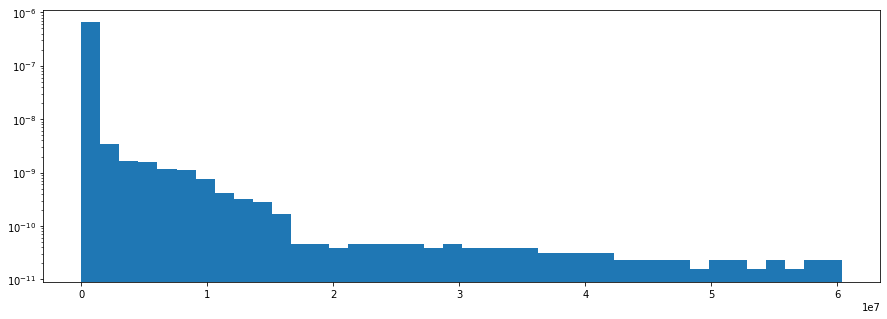

In [ ]:
plt.hist(df['Confirmed'], density=True, bins=40) 
plt.yscale('log')

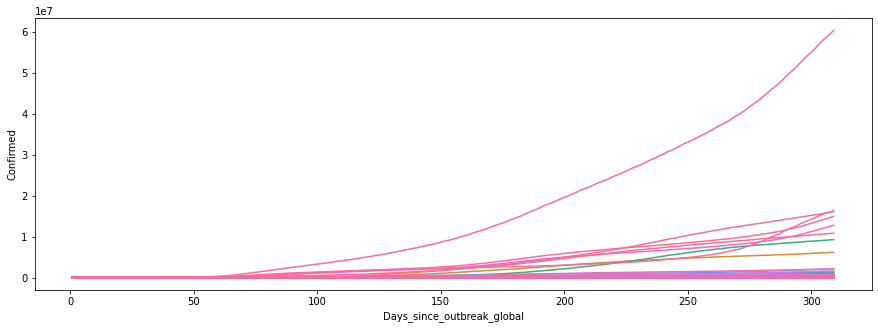

In [ ]:
ax=sns.lineplot(data=df, hue="Country", x="Days_since_outbreak_global", y="Confirmed", ci=None)
ax.legend_.remove()

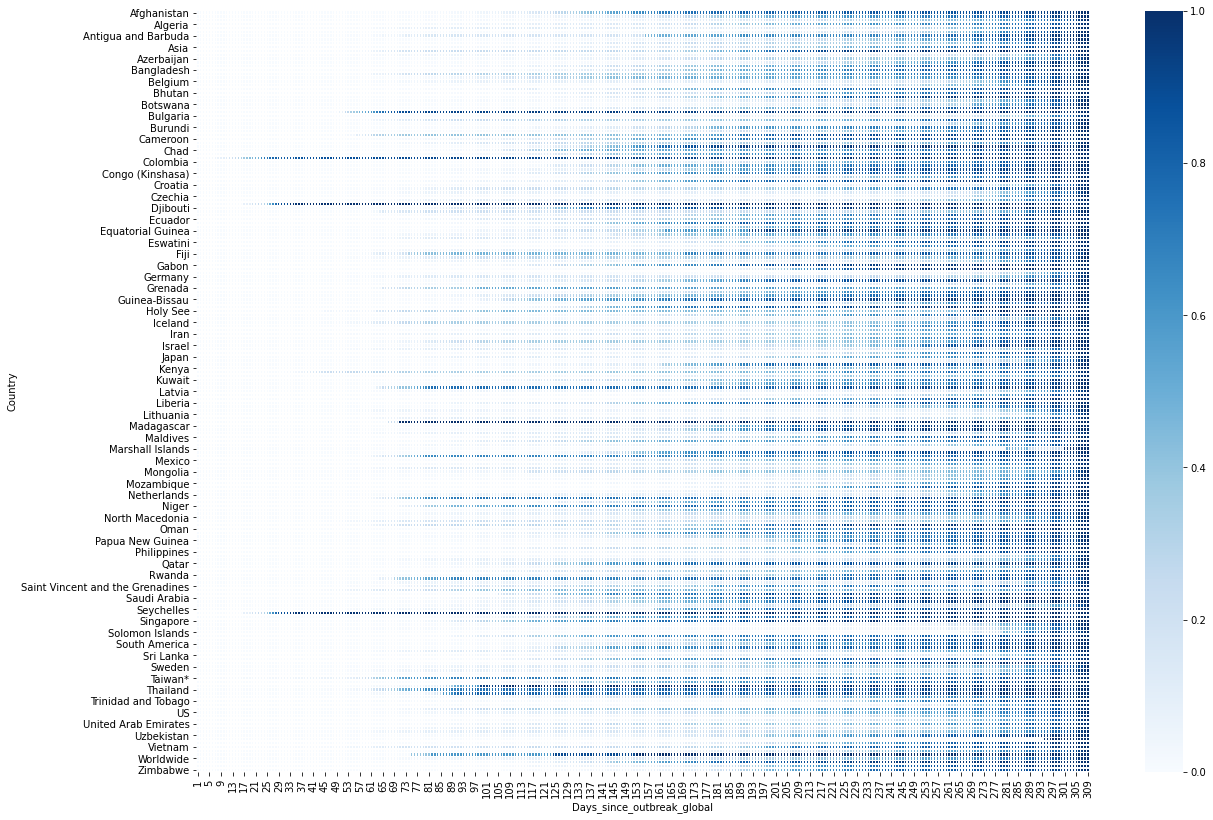

In [ ]:
def group_and_chart(Geography, Figure, Data):
    grouped = Data.copy()
    grouped = grouped.groupby(['Days_since_outbreak_global',Geography])[Figure].sum()
    grouped = pd.DataFrame(grouped) 
    grouped.reset_index(inplace=True)
    grouped = grouped.pivot(index=Geography, columns='Days_since_outbreak_global', values=Figure)
    grouped = grouped.T[(grouped != 0).any()].T
    grouped = grouped.transpose()
    grouped.fillna(0, inplace=True)
    min_max_scaler = preprocessing.MinMaxScaler()
    grouped_temp = min_max_scaler.fit_transform(grouped)
    grouped = pd.DataFrame(grouped_temp, index=grouped.index, columns=grouped.columns)
    grouped = grouped.transpose()
    rcParams['figure.figsize'] = 20, 14
    sns.heatmap(grouped, cmap="Blues", linewidth=.5)
    
group_and_chart(Geography='Country', Figure='Confirmed', Data=df)

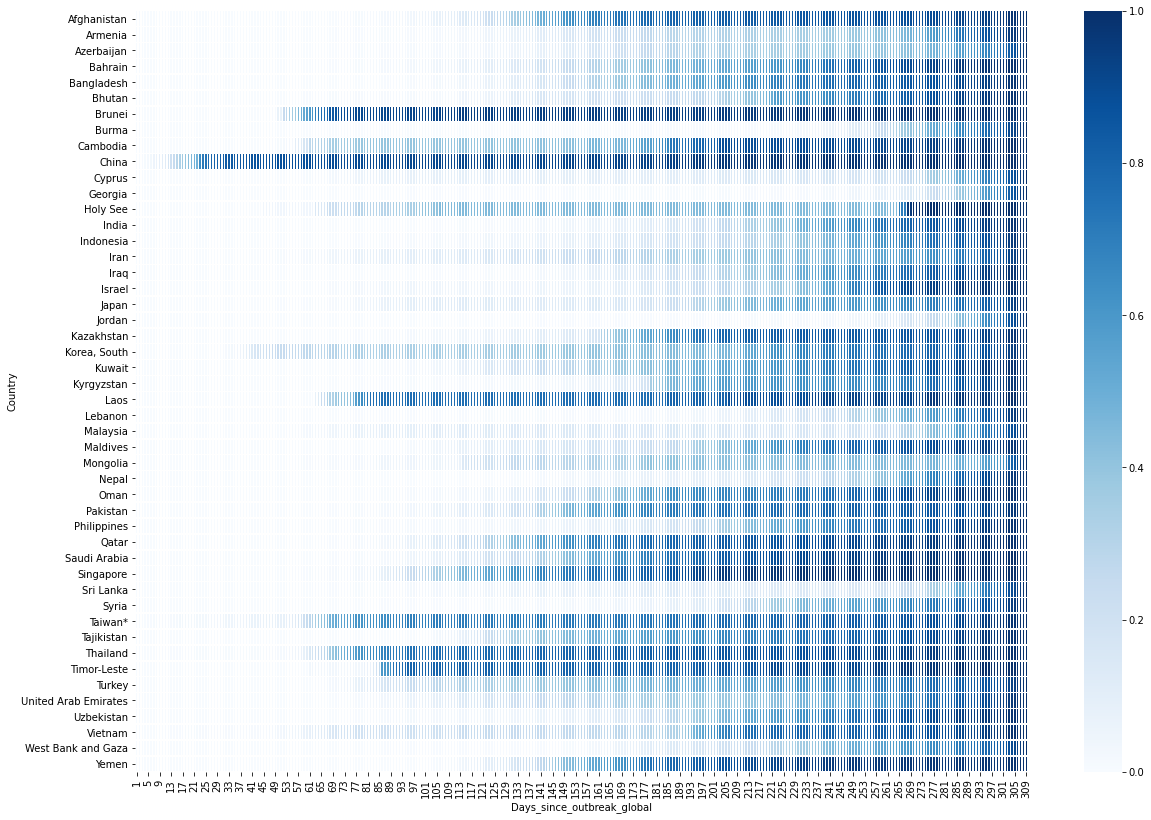

In [ ]:
df_ = df.copy()
df_ = df_.loc[(df.Continent == 'Asia')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

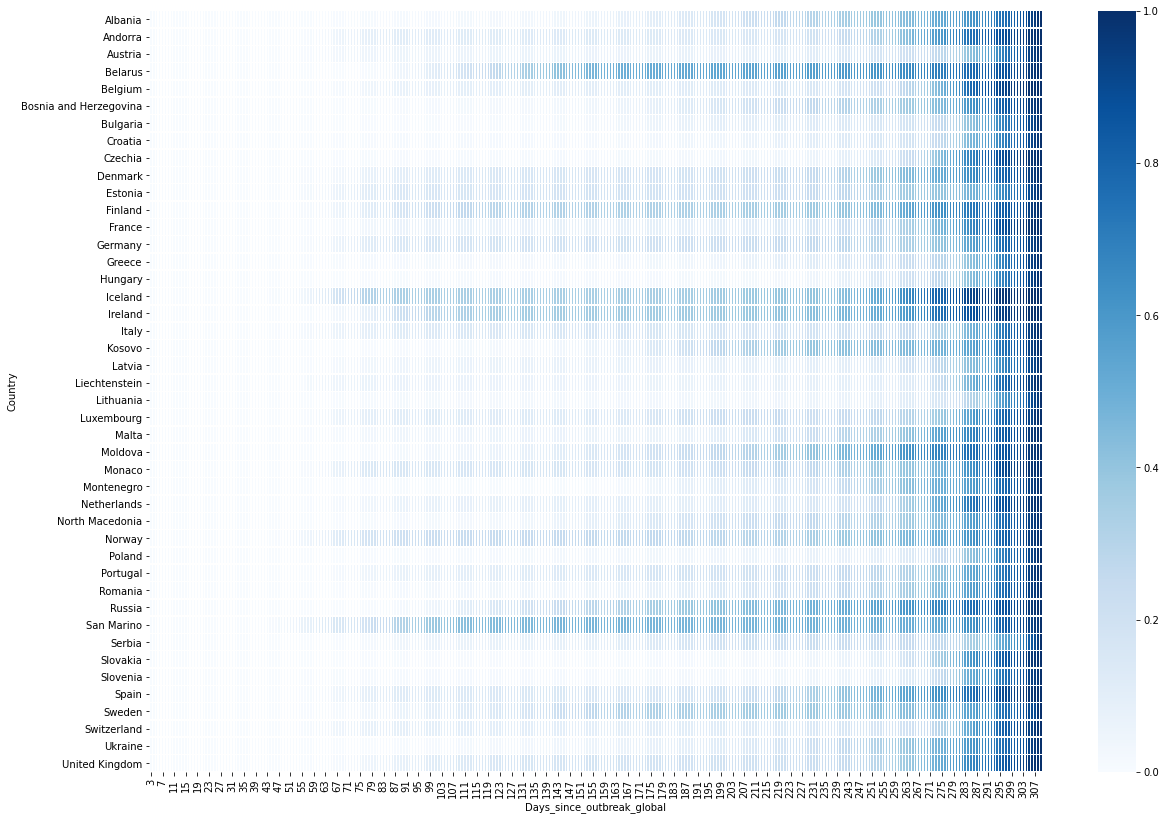

In [ ]:
df_ = df.loc[(df.Continent == 'Europe')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

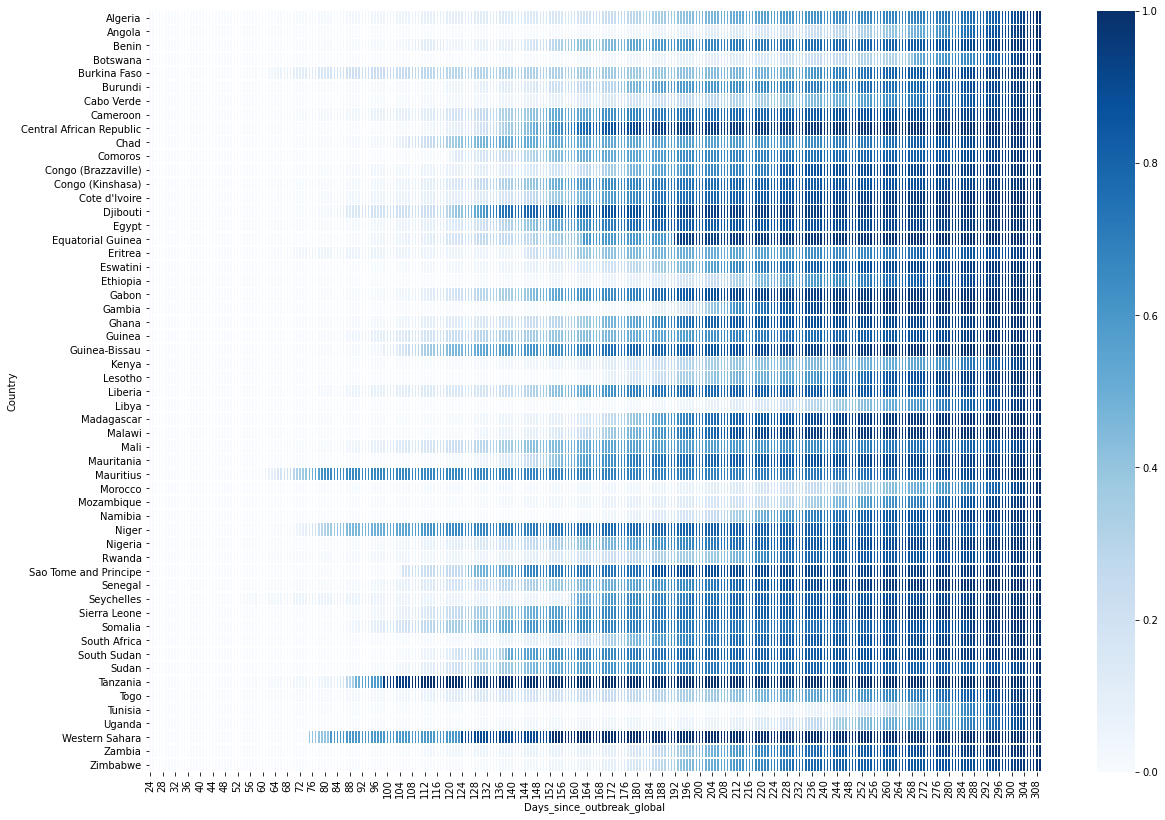

In [ ]:
df_ = df.loc[(df.Continent == 'Africa')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

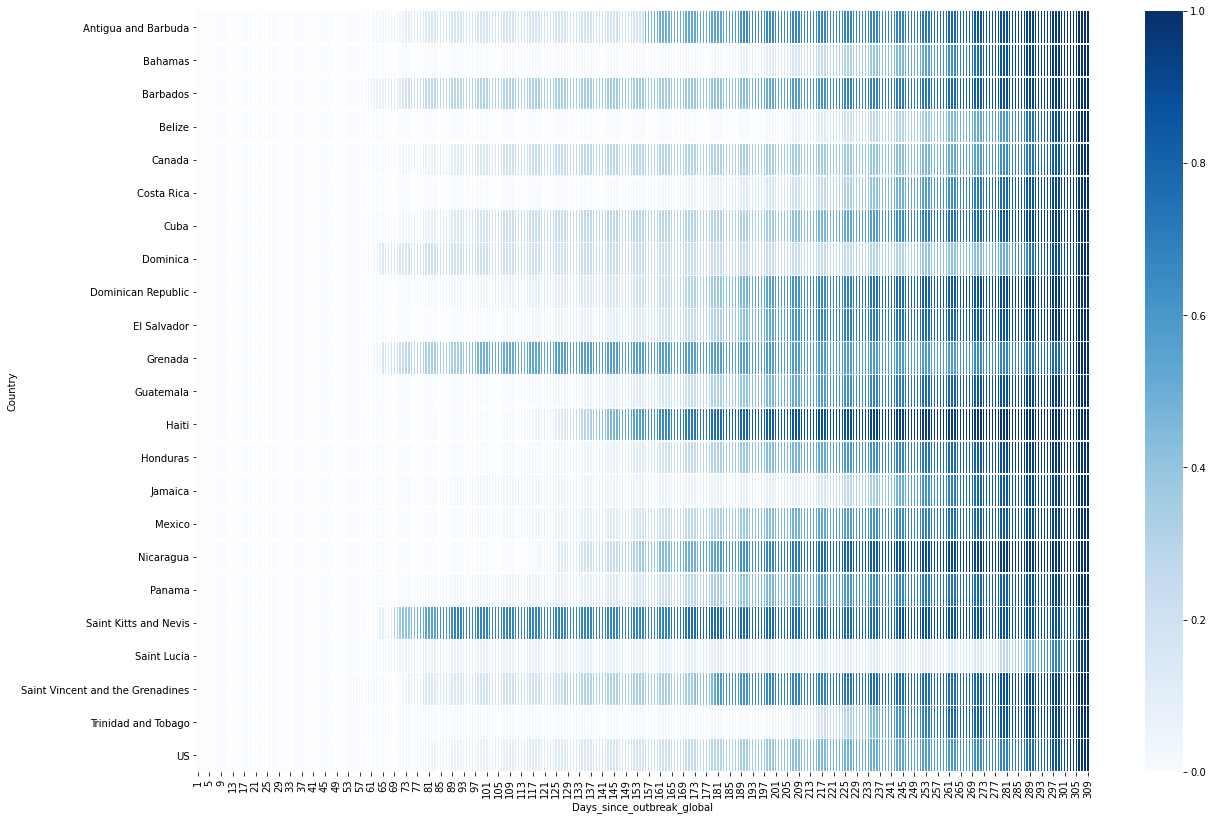

In [ ]:
df_ = df.loc[(df.Continent == 'North America')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

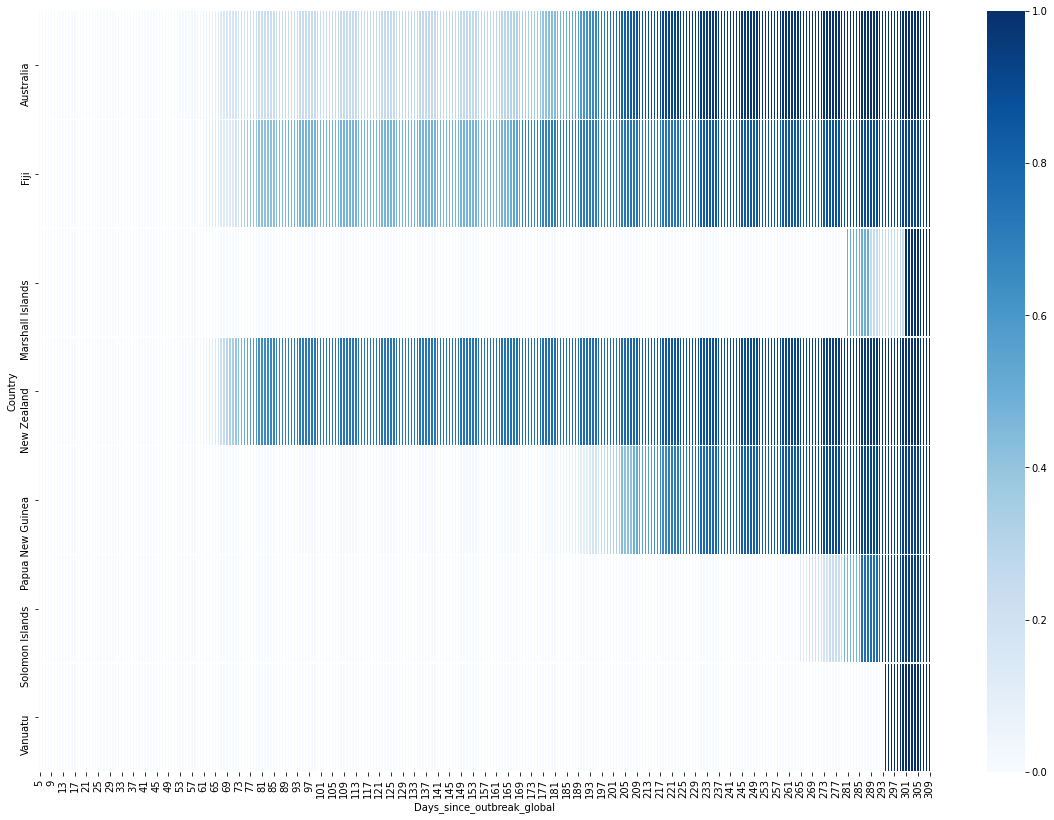

In [ ]:
df_ = df.loc[(df.Continent == 'Oceania')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

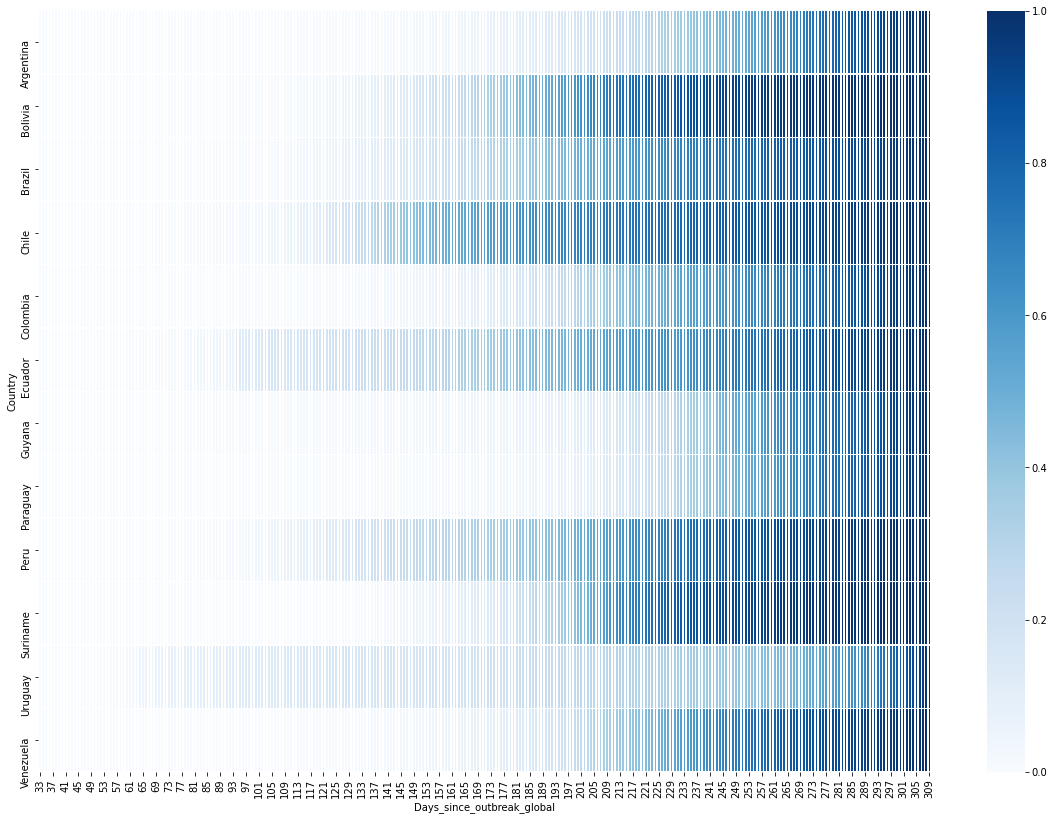

In [ ]:
df_ = df.loc[(df.Continent == 'South America')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

## Analysis - daily increase

In [ ]:
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday
df['Week_number'] = df['Date'].dt.week
df['Quarter'] = df['Date'].dt.quarter
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Confirmed_lag_1'] = df.groupby('Province_and_country')['Confirmed'].shift(1)
df['Daily_increase_confirmed'] = df['Confirmed']-df['Confirmed_lag_1']
df = df.replace([np.inf, -np.inf], np.nan)
#df.loc[df['Daily_increase_confirmed'] == np.inf, 'Daily_increase_confirmed'] = df['Confirmed']
#df.loc[df['Daily_increase_death'] == np.inf, 'Daily_increase_death'] = df['Deaths']
df = df.replace(np.nan, 0)
df

,Confirmed,Continent,Country,Country_Region,Date,Province,Province_and_country,iso2,Days_since_outbreak_global,Day,Weekday,Week_number,Quarter,Month,Year,Confirmed_lag_1,Daily_increase_confirmed
0,0,Asia,Afghanistan,Afghanistan,2020-01-22,0,Afghanistan,AF,1,22,2,4,1,1,2020,0.00,0.00
1,0,Europe,Albania,Albania,2020-01-22,0,Albania,AL,1,22,2,4,1,1,2020,0.00,0.00
2,0,Africa,Algeria,Algeria,2020-01-22,0,Algeria,DZ,1,22,2,4,1,1,2020,0.00,0.00
3,0,Europe,Andorra,Andorra,2020-01-22,0,Andorra,AD,1,22,2,4,1,1,2020,0.00,0.00
4,0,Africa,Angola,Angola,2020-01-22,0,Angola,AO,1,22,2,4,1,1,2020,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86206,16351903,0,Europe,0,2020-11-25,0,Europe,0,309,25,2,48,4,11,2020,16115365.00,236538.00
86207,14944351,0,North America,0,2020-11-25,0,North America,0,309,25,2,48,4,11,2020,14742522.00,201829.00
86208,30610,0,Oceania,0,2020-11-25,0,Oceania,0,309,25,2,48,4,11,2020,30582.00,28.00
86209,721,0,Ships,0,2020-11-25,0,Ships,0,309,25,2,48,4,11,2020,721.00,0.00


In [ ]:
df.to_csv('df_m.CSV',sep=',')

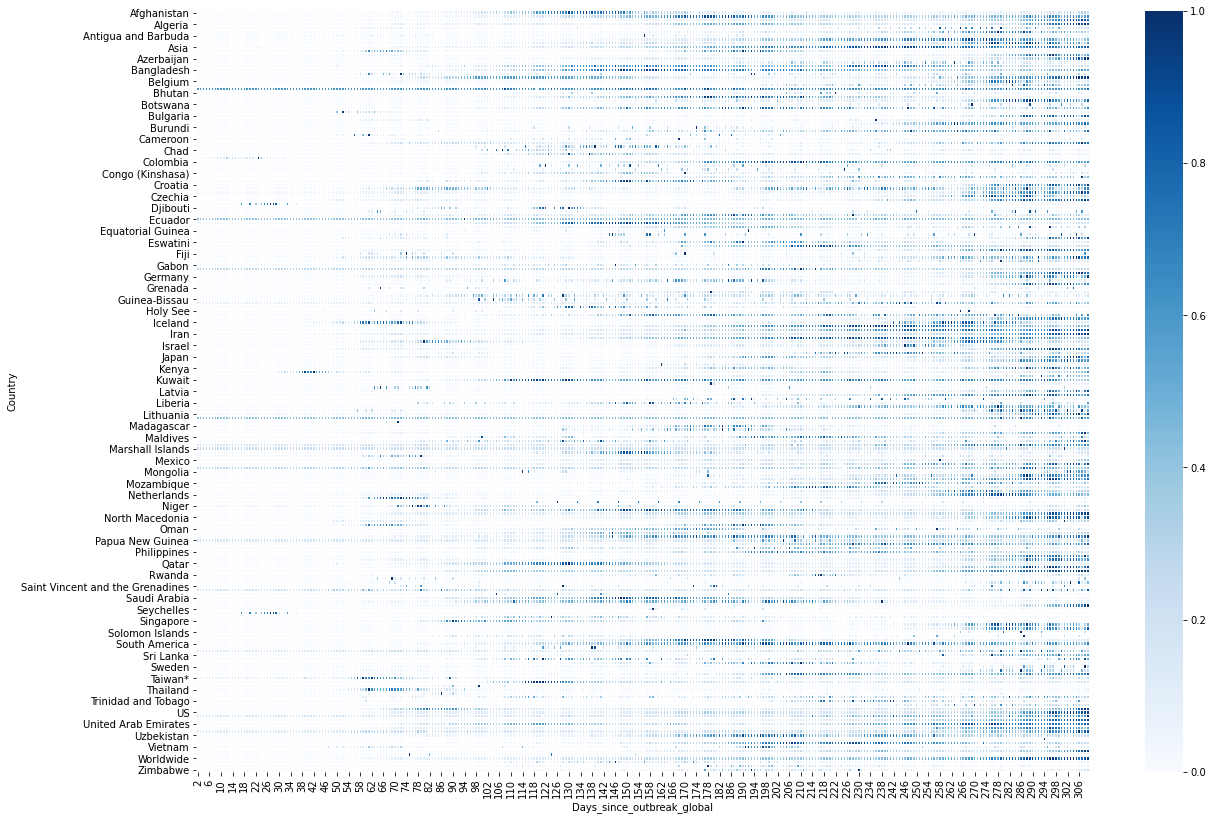

In [ ]:
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df)

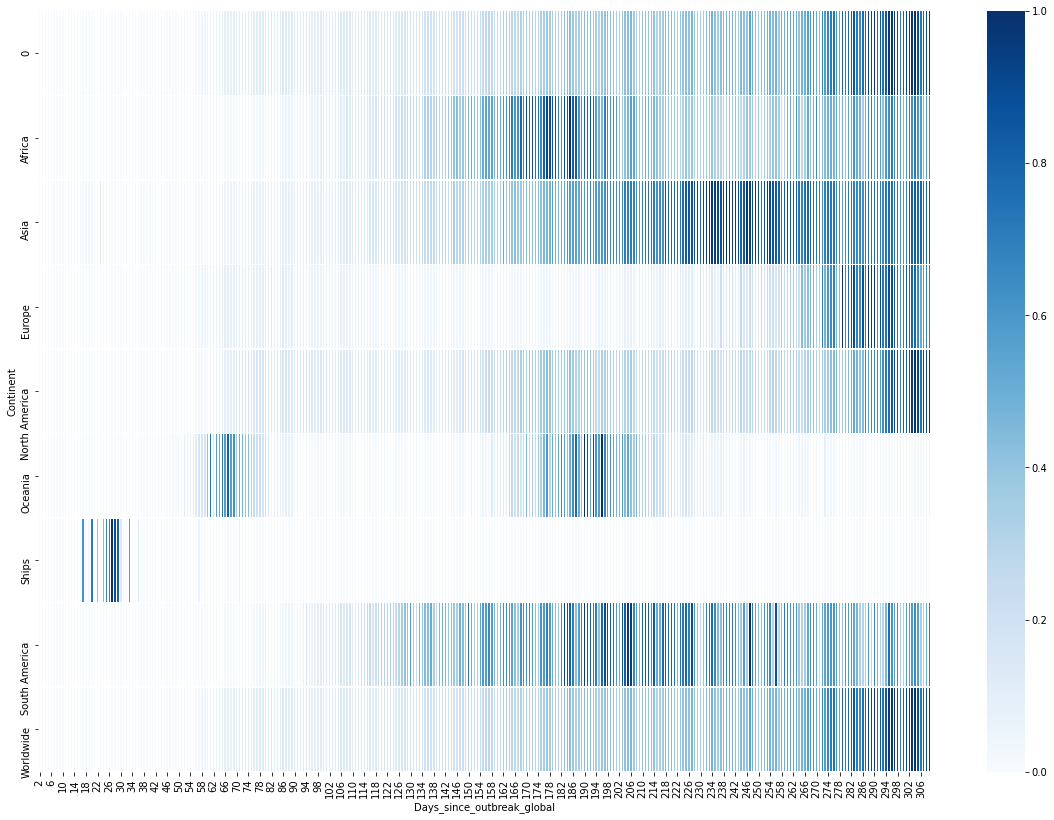

In [ ]:
group_and_chart(Geography='Continent', Figure='Daily_increase_confirmed', Data=df)

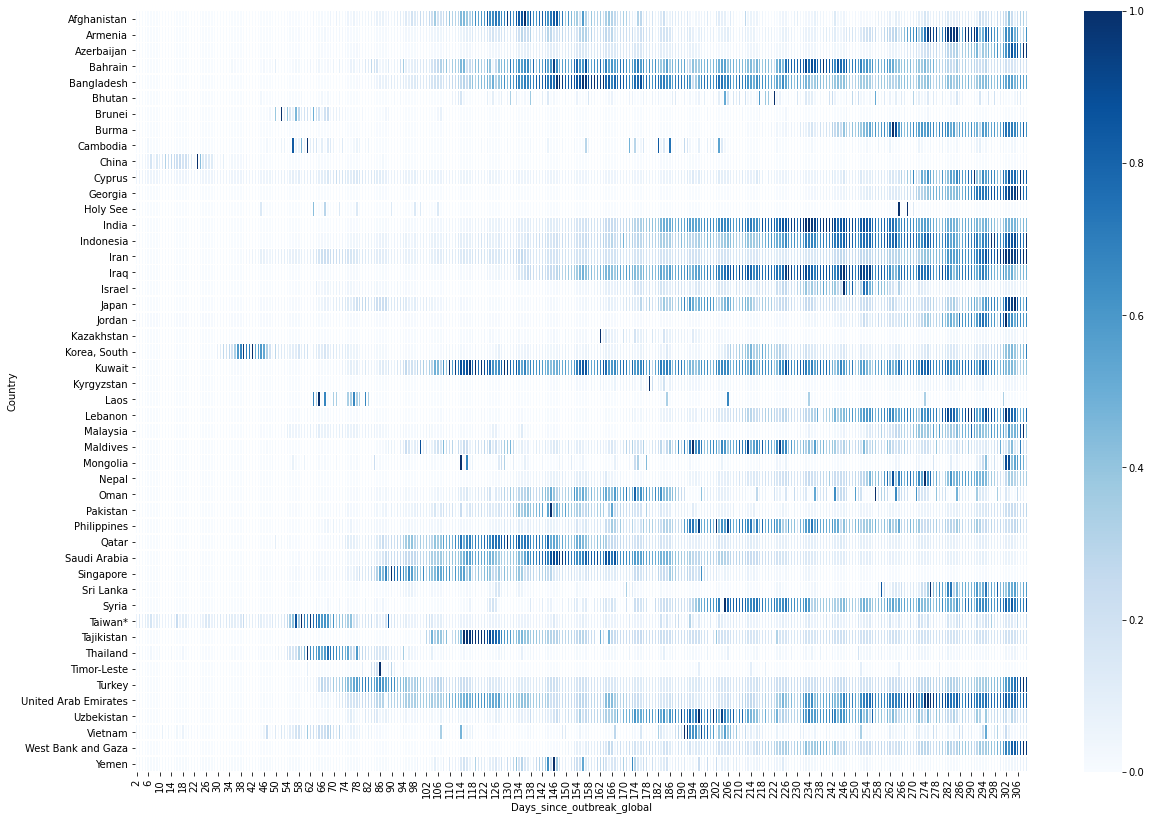

In [ ]:
df_ = df.loc[(df.Continent == 'Asia')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

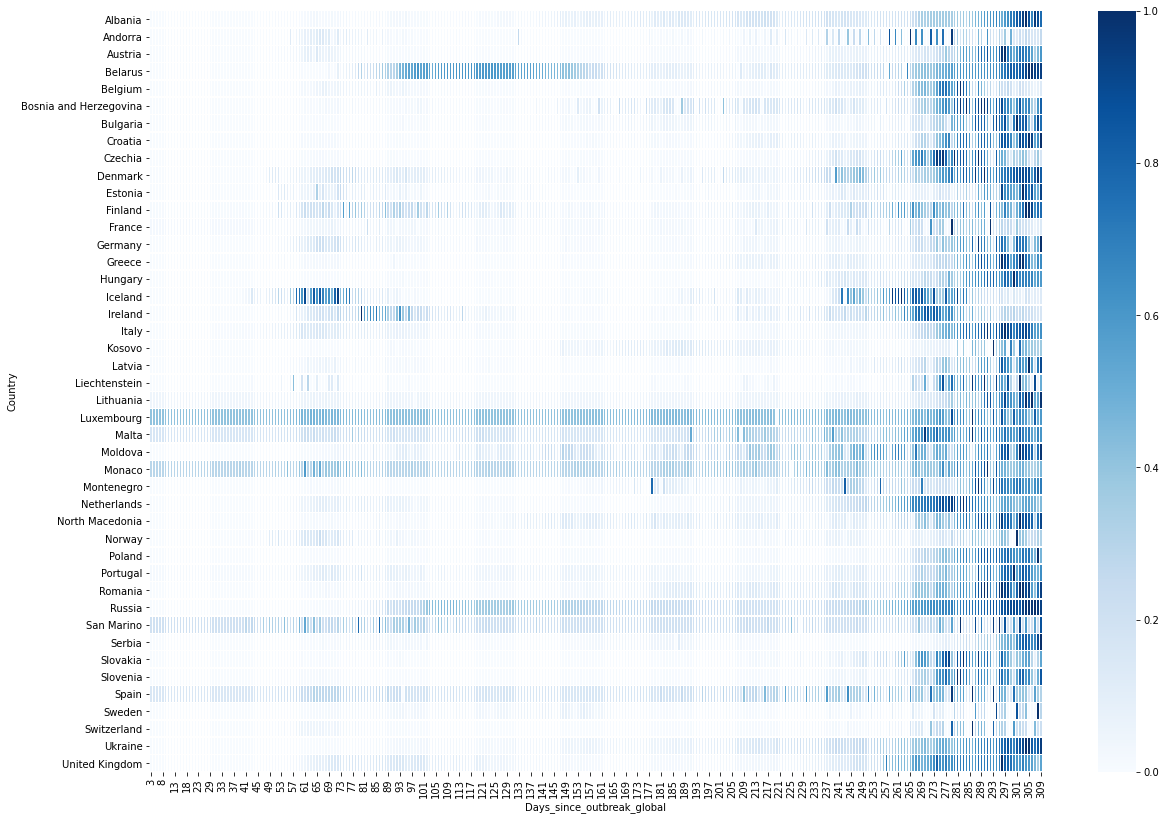

In [ ]:
df_ = df.loc[(df.Continent == 'Europe')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

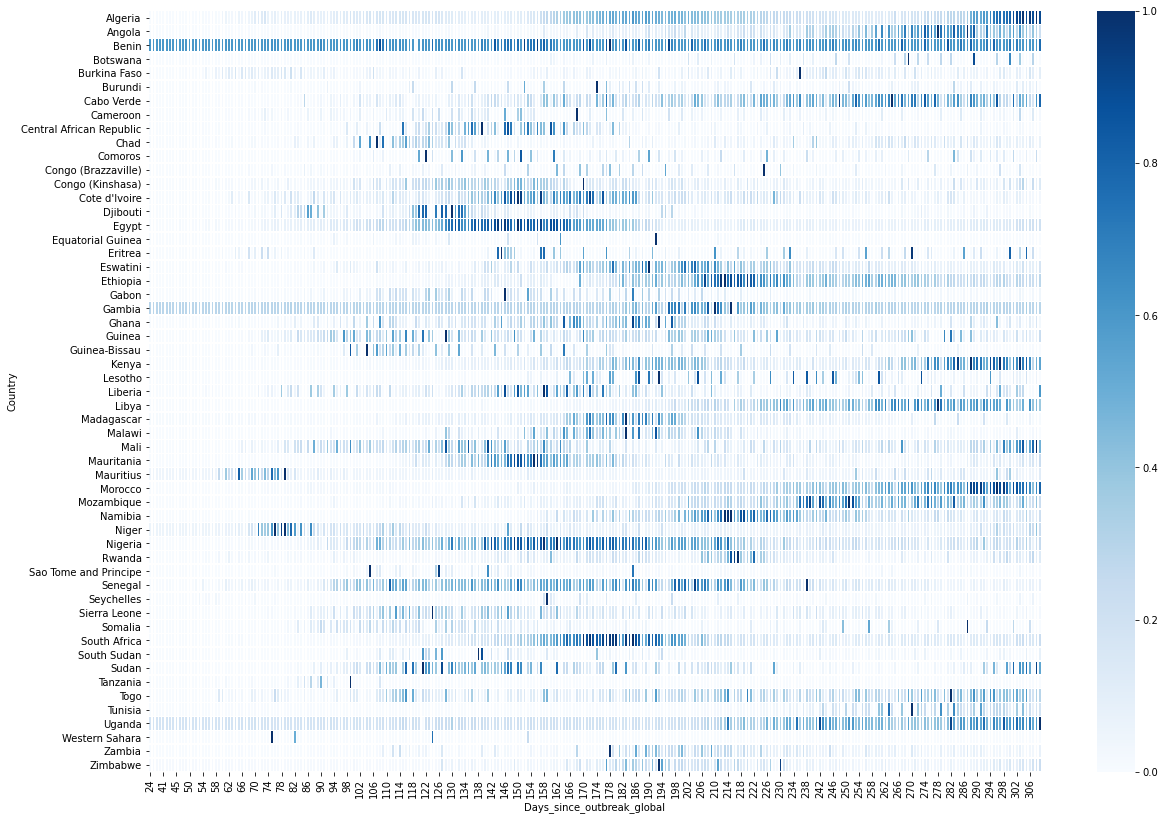

In [ ]:
df_ = df.loc[(df.Continent == 'Africa')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

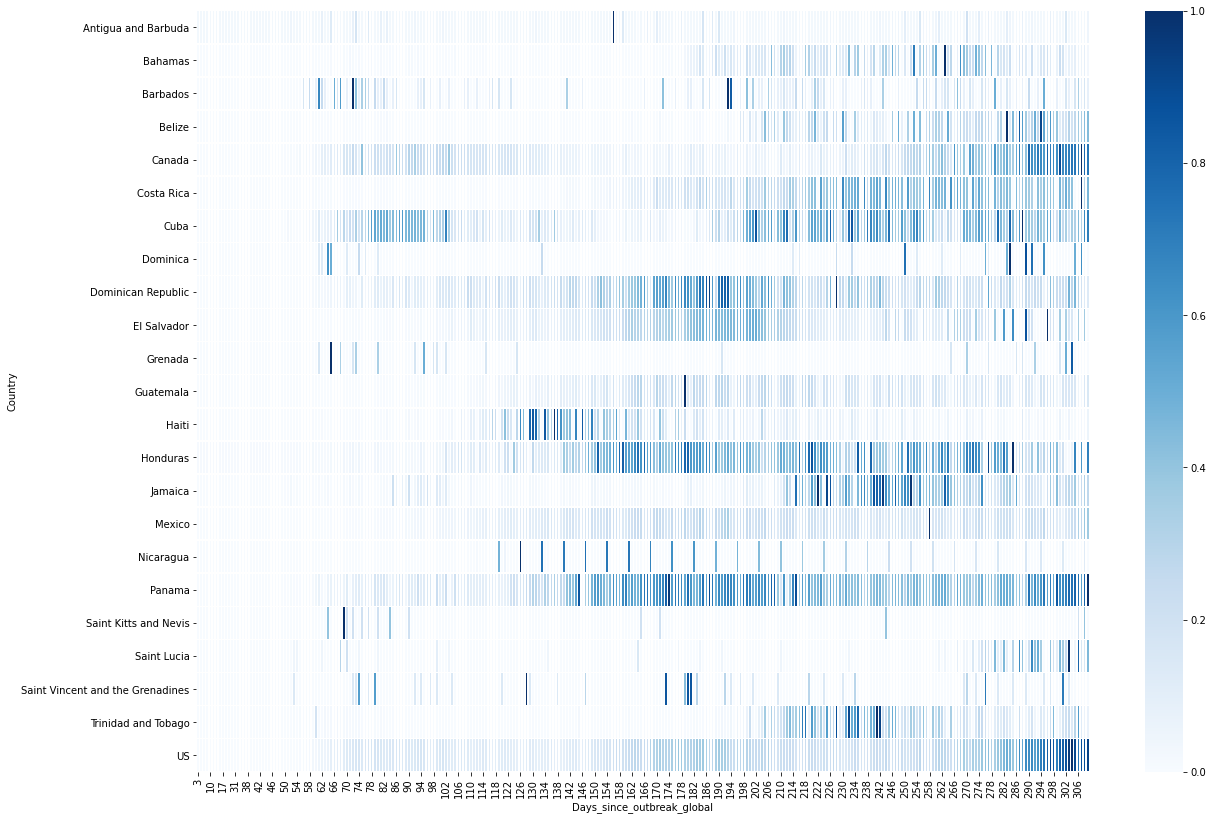

In [ ]:
df_ = df.loc[(df.Continent == 'North America')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

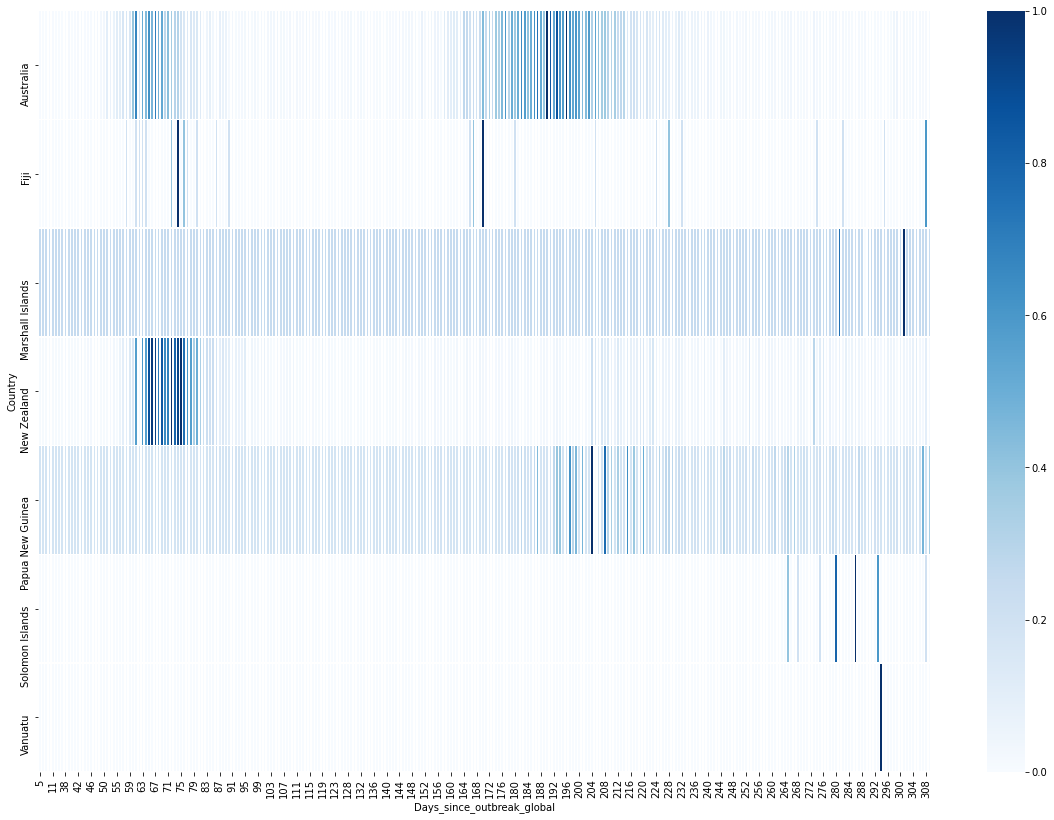

In [ ]:
df_ = df.loc[(df.Continent == 'Oceania')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

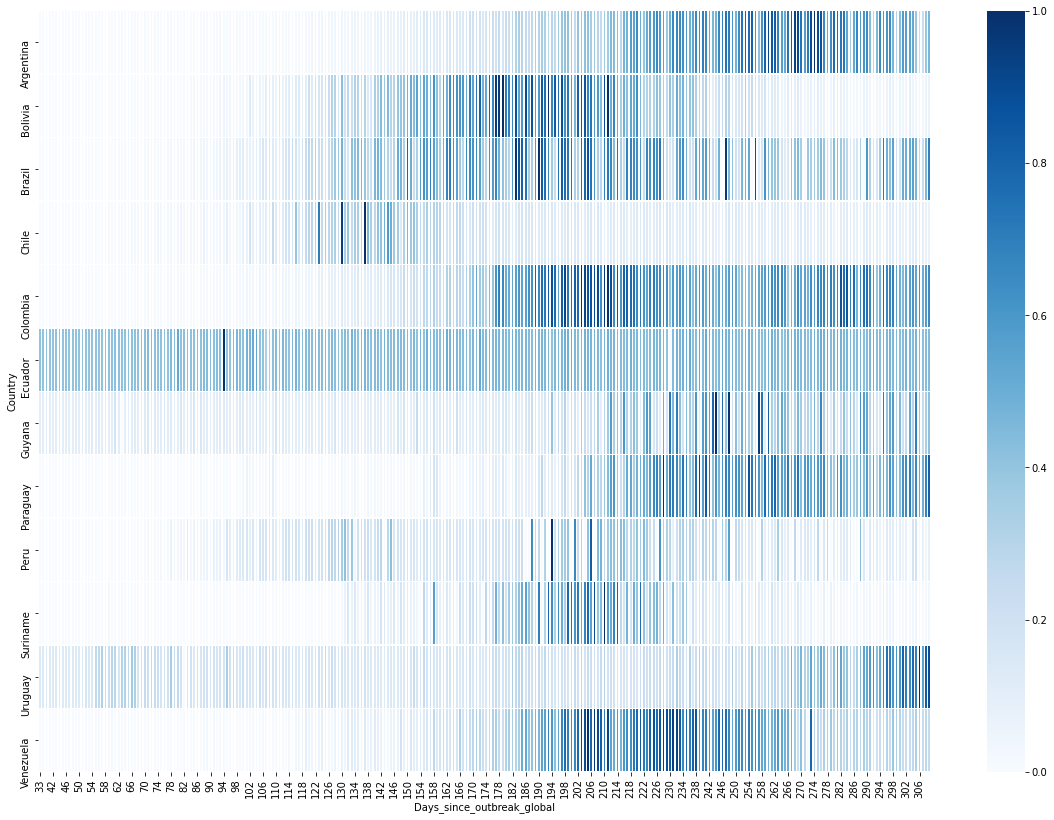

In [ ]:
df_ = df.loc[(df.Continent == 'South America')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

In [ ]:
rcParams['figure.figsize'] = 15, 5

## Prediction

### Definition of Datasets

In [ ]:
#Create Train dataset
df_ml_confirmed = df.copy()
df_ml_confirmed['Confirmed_lag_1'] = df_ml_confirmed.groupby('Province_and_country')['Confirmed'].shift(1)
df_ml_confirmed['Confirmed_orig'] = df_ml_confirmed['Confirmed']
df_ml_confirmed['Confirmed'] = df_ml_confirmed['Confirmed']-df_ml_confirmed['Confirmed_lag_1']
df_ml_confirmed['Confirmed_lag_1'] = df_ml_confirmed.groupby('Province_and_country')['Confirmed'].shift(1)
df_ml_confirmed['Confirmed_detrend'] = df_ml_confirmed['Confirmed']-df_ml_confirmed['Confirmed_lag_1']
df_ml_confirmed['Confirmed_lag_7'] = df_ml_confirmed.groupby('Province_and_country')['Confirmed'].shift(7)
df_ml_confirmed['Confirmed_SMA_7'] = df_ml_confirmed.groupby('Province_and_country')['Confirmed_lag_7'].transform(lambda x: x.rolling(7).mean())
df_ml_confirmed['Confirmed_EMA_7'] = df_ml_confirmed.groupby('Province_and_country')['Confirmed_lag_7'].transform(lambda x: x.ewm(7).mean())
df_ml_confirmed = df_ml_confirmed.reset_index(drop=True)
df_ml_confirmed['Days_since_outbreak_country'] = df_ml_confirmed.loc[(df_ml_confirmed.Confirmed.notnull())].groupby(['Province_and_country']).cumcount()+1
df_ml_confirmed = df_ml_confirmed.replace(np.nan, 0)
df_ml_confirmed = df_ml_confirmed[['Confirmed_detrend','Confirmed_orig','Confirmed', 'Province_and_country', 'Days_since_outbreak_global', 'Date','Day','Weekday','Week_number','Quarter','Month','Year','Confirmed_lag_7','Days_since_outbreak_country','Confirmed_SMA_7','Confirmed_EMA_7']]
df_ml_confirmed = df_ml_confirmed.reset_index(drop=True)
df_ml_confirmed.head(5)

,Confirmed_detrend,Confirmed_orig,Confirmed,Province_and_country,Days_since_outbreak_global,Date,Day,Weekday,Week_number,Quarter,Month,Year,Confirmed_lag_7,Days_since_outbreak_country,Confirmed_SMA_7,Confirmed_EMA_7
0,0.00,0,0.00,Afghanistan,1,2020-01-22,22,2,4,1,1,2020,0.00,0.00,0.00,0.00
1,0.00,0,0.00,Albania,1,2020-01-22,22,2,4,1,1,2020,0.00,0.00,0.00,0.00
2,0.00,0,0.00,Algeria,1,2020-01-22,22,2,4,1,1,2020,0.00,0.00,0.00,0.00
3,0.00,0,0.00,Andorra,1,2020-01-22,22,2,4,1,1,2020,0.00,0.00,0.00,0.00
4,0.00,0,0.00,Angola,1,2020-01-22,22,2,4,1,1,2020,0.00,0.00,0.00,0.00


### Definition of Variables

In [ ]:
split_date = datetime.today() - timedelta(days=8)
split_date

datetime.datetime(2020, 11, 18, 10, 27, 24, 779968)

In [ ]:
cut_date = datetime.today() - timedelta(days=1)
cut_date

datetime.datetime(2020, 11, 25, 10, 27, 26, 515140)

In [ ]:
def create_x_y(df, label=None):
    df.index = df['Date']
    X = df[['Days_since_outbreak_global','Day','Weekday','Week_number','Quarter','Month','Year', 'Confirmed_lag_7','Confirmed_SMA_7','Confirmed_EMA_7','Days_since_outbreak_country']]
    if label:
        y = df[label]
        return X, y
    return X

In [ ]:
def create_x_y_simple(df, label=None):
    df.index = df['Date']
    X = df[['Days_since_outbreak_global']]
    if label:
        y = df[label]
        return X, y
    return X

In [ ]:
def create_x_y_simple_2(df, label=None):
    df.index = df['Date']
    X = df[['Days_since_outbreak_global','Weekday']]
    if label:
        y = df[label]
        return X, y
    return X

In [ ]:
def create_x_y_simple_3(df, label=None):
    df.index = df['Date']
    X = df[['Days_since_outbreak_global','Weekday', 'Confirmed_lag_7']]
    if label:
        y = df[label]
        return X, y
    return X

In [ ]:
def root_mean_squared_log_error(real, predicted):
    sum=0.0
    for x in range(len(predicted)):
        if predicted[x]<0 or real[x]<0: # check for negative values
            continue
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5

### One Country Test

#### Linear Regression

##### Article

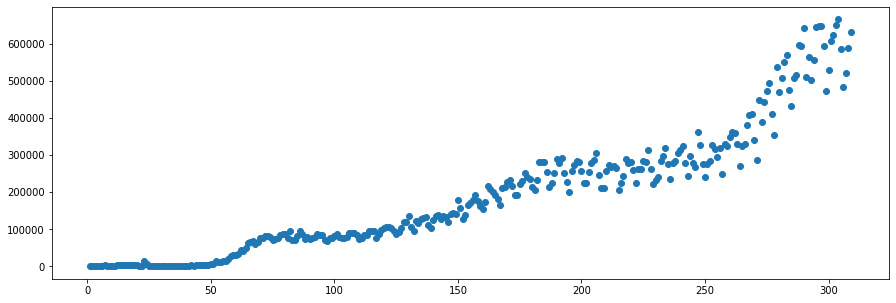

In [ ]:
#Chart 1
List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Worldwide")]
List = List.loc[List.Date <= cut_date].copy()
plt.scatter(List['Days_since_outbreak_global'],List['Confirmed'])
plt.show()

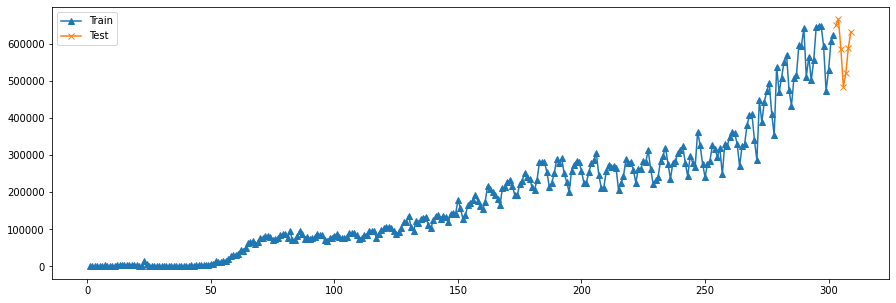

In [ ]:
#Chart 2
Confirmed_train = List.loc[List.Date <= split_date].copy()
Confirmed_test = List.loc[(List.Date > split_date) & (List.Date <= cut_date)].copy()

plt.plot(Confirmed_train['Days_since_outbreak_global'],Confirmed_train['Confirmed'], Label="Train", marker='^')
plt.plot(Confirmed_test['Days_since_outbreak_global'],Confirmed_test['Confirmed'], Label="Test", marker='x')
plt.legend(loc='best')
plt.show()

In [ ]:
#Simple Linear Regression
Confirmed_train = List.loc[List.Date <= split_date].copy()
Confirmed_test = List.loc[(List.Date > split_date) & (List.Date <= cut_date)].copy()

X_train, y_train = create_x_y_simple(Confirmed_train, label='Confirmed')
X_test, y_test = create_x_y_simple(Confirmed_test, label='Confirmed')

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

linear_regressor = LinearRegression(fit_intercept=True)  # create object for the class
linear_regressor.fit(X_train, y_train)
print(linear_regressor.intercept_, '- Intercept')
print(linear_regressor.coef_, '- Coefficient')

Confirmed_test['Confirmed_Prediction'] = linear_regressor.predict(X_test)

print("Train/Test Score - MAE: {0:.3f}".format(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])))
print("Train/Test Score - RMSE: {0:.3f}".format(np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))))
print("Train/Test Score - RMSLE: {0:.3f}".format(root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])))

-71924.22703570873 - Intercept
[1704.43718586] - Coefficient
Train/Test Score - MAE: 140350.162
Train/Test Score - RMSE: 154072.433
Train/Test Score - RMSLE: 0.288


[1704.43718586] -71924.22703570873


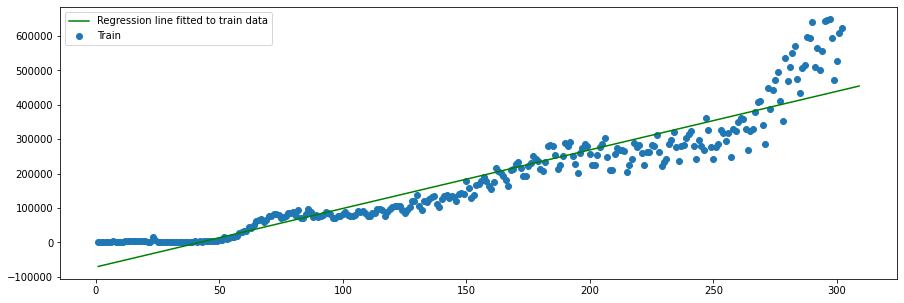

In [ ]:
#Chart 3
y_pred = linear_regressor.predict(X_test)
x1 = np.array(List['Days_since_outbreak_global'])
y1 = np.array(List['Confirmed'])

m = linear_regressor.coef_
b = linear_regressor.intercept_
print(m,b)
plt.scatter(Confirmed_train['Days_since_outbreak_global'],Confirmed_train['Confirmed'], Label="Train")
plt.plot(x1, b + m * x1, '-', Label='Regression line fitted to train data', color='Green')
plt.legend(loc='best')
plt.show()

[1704.43718586] -71924.22703570873


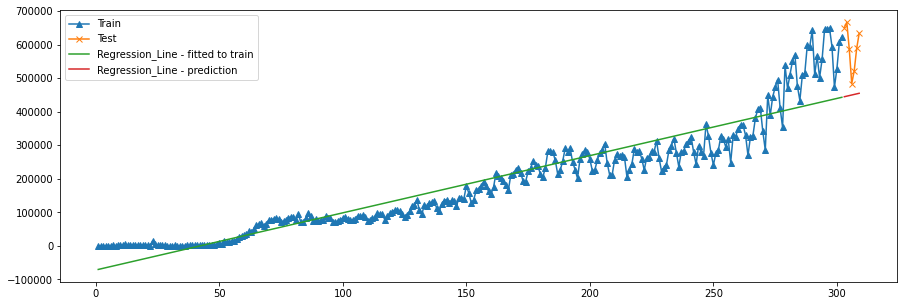

In [ ]:
#Chart 4
y_pred = linear_regressor.predict(X_test)
x1_train = np.array(Confirmed_train['Days_since_outbreak_global'])
y1_train = np.array(Confirmed_train['Confirmed'])

x1_test = np.array(Confirmed_test['Days_since_outbreak_global'])
y1_test = np.array(Confirmed_test['Confirmed'])

print(m,b)
plt.plot(Confirmed_train['Days_since_outbreak_global'],Confirmed_train['Confirmed'], Label="Train", marker='^')
plt.plot(Confirmed_test['Days_since_outbreak_global'],Confirmed_test['Confirmed'], Label="Test", marker='x')
plt.plot(x1_train, b + m * x1_train, '-', Label='Regression_Line - fitted to train' )
plt.plot(x1_test, b + m * x1_test, '-', Label='Regression_Line - prediction' )
plt.legend(loc='best')
plt.show()

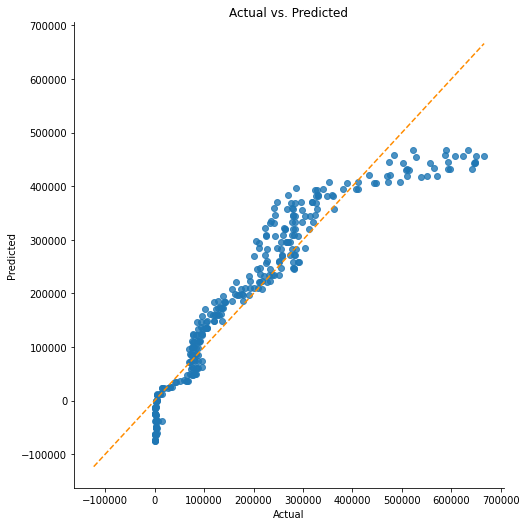

In [ ]:
#Linearity test - two variables
X_list, y_list = create_x_y_simple_2(List, label='Confirmed')
linear_regressor = LinearRegression(fit_intercept=True)  # create object for the class
linear_regressor.fit(X_list, y_list)
y_pred_all = linear_regressor.predict(X_list)
Pred_all = pd.DataFrame({'Predicted': y_pred_all, 'Days_since_outbreak_global':X_list['Days_since_outbreak_global'],'Actual':y_list, 'Weekday':X_list['Weekday']})
Pred_all['Residuals'] = abs(Pred_all['Actual']) - abs(Pred_all['Predicted'])


# Plotting the actual vs predicted values
sns.lmplot(x='Actual', y='Predicted', data=Pred_all, fit_reg=False, size=7)
        
# Plotting the diagonal line
line_coords = np.arange(Pred_all.min().min(), Pred_all.max().max())
plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
plt.title('Actual vs. Predicted')
plt.show()

Residuals are not normally distributed


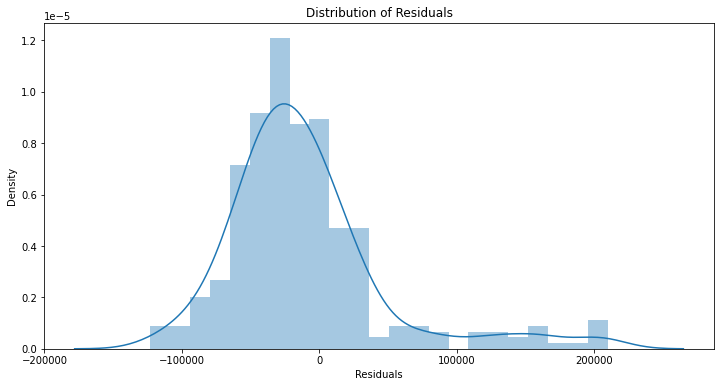

In [ ]:
#Normality test - two variables
p_value = normal_ad(Pred_all['Residuals'])[1]
p_value_thresh=0.05
if p_value < p_value_thresh:
    print('Residuals are not normally distributed')
else:
    print('Residuals are normally distributed')

# Plotting the residuals distribution
plt.subplots(figsize=(12, 6))
plt.title('Distribution of Residuals')
sns.distplot(Pred_all['Residuals'])
plt.show()

In [ ]:
#Multicolinearity and Stats Report - two variables
X = X_list.copy()
y = y_list.copy()
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
print(results.summary())

variables = results.model.exog
vif = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
vif 

                            OLS Regression Results                            
Dep. Variable:              Confirmed   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     1087.
Date:                Thu, 26 Nov 2020   Prob (F-statistic):          8.83e-140
Time:                        12:36:56   Log-Likelihood:                -3833.2
No. Observations:                 309   AIC:                             7672.
Df Residuals:                     306   BIC:                             7684.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

[6.3142199871831135, 1.0000704146378991, 1.0000704146378994]

In [ ]:
#Autocorrelation - two variables
durbinWatson = durbin_watson(Pred_all['Residuals'])
print('Durbin-Watson:', durbinWatson)
print ('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')

Durbin-Watson: 0.2991782310693473
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data


In [ ]:
#Linearity test - three variables
X_list, y_list = create_x_y_simple_3(List, label='Confirmed')
linear_regressor = LinearRegression(fit_intercept=True)  # create object for the class
linear_regressor.fit(X_list, y_list)
y_pred_all = linear_regressor.predict(X_list)
Pred_all = pd.DataFrame({'Predicted': y_pred_all, 'Days_since_outbreak_global':X_list['Days_since_outbreak_global'],'Actual':y_list, 'Weekday':X_list['Weekday'], 'Confirmed_lag_7':X_list['Confirmed_lag_7']})
Pred_all['Residuals'] = abs(Pred_all['Actual']) - abs(Pred_all['Predicted'])

In [ ]:
#Autocorrelation - three variables
durbinWatson = durbin_watson(Pred_all['Residuals'])
print('Durbin-Watson:', durbinWatson)
print ('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')

Durbin-Watson: 1.3359235468636972
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data


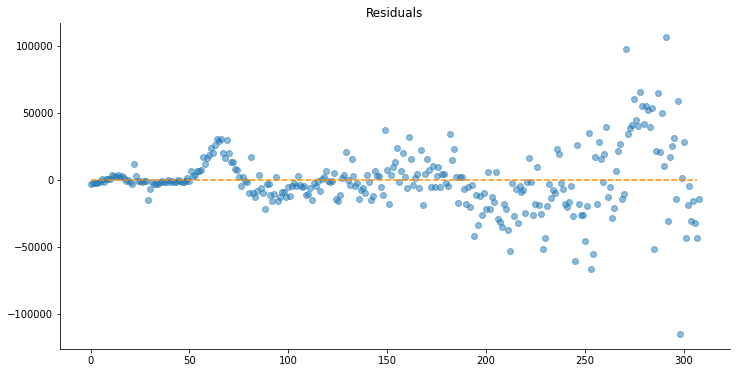

In [ ]:
#Homoscedasticity - three variables
plt.subplots(figsize=(12, 6))
Pred_all = Pred_all.reset_index(drop=True)
ax = plt.subplot(111)  # To remove spines
plt.scatter(x=Pred_all.index, y=Pred_all.Residuals, alpha=0.5)
plt.plot(np.repeat(0, Pred_all.index.max()), color='darkorange', linestyle='--')
ax.spines['right'].set_visible(False)  # Removing the right spine
ax.spines['top'].set_visible(False)  # Removing the top spine
plt.title('Residuals')
plt.show()  

In [ ]:
#Multicolinearity and Stats Report - three variables
X = X_list.copy()
y = y_list.copy()
X = X.subtract(X.mean())
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
print(results.summary())

variables = results.model.exog
vif = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
vif 

                            OLS Regression Results                            
Dep. Variable:              Confirmed   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     5341.
Date:                Thu, 26 Nov 2020   Prob (F-statistic):          3.38e-263
Time:                        12:37:08   Log-Likelihood:                -3541.6
No. Observations:                 309   AIC:                             7091.
Df Residuals:                     305   BIC:                             7106.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

[1.0, 8.140452036337765, 1.0021870216794355, 8.1445613607218]

##### Main

Train/Test Score - MAE: 21268.383
Train/Test Score - RMSE: 25442.015
Train/Test Score - RMSLE: 0.043


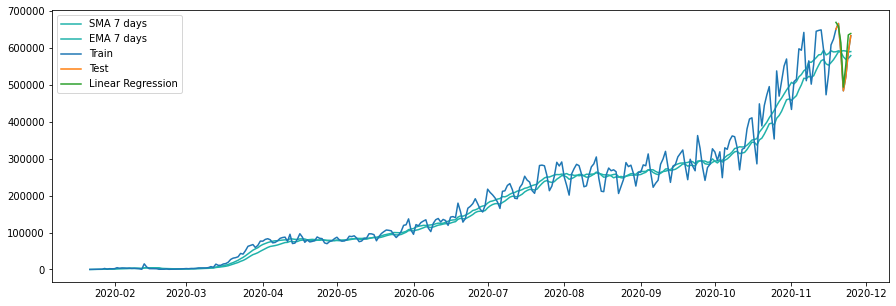

In [ ]:
#Linear Regression
List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Worldwide")]
 
Confirmed_train = List.loc[List.Date <= split_date].copy()
Confirmed_test = List.loc[(List.Date > split_date) & (List.Date <= cut_date)].copy()

X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

linear_regressor = LinearRegression(fit_intercept=False)  # create object for the class
linear_regressor.fit(X_train, y_train)

Confirmed_test['File_type'] = "Test"
Confirmed_train['File_type'] = "Train"

Confirmed_test['Confirmed_Prediction'] = linear_regressor.predict(X_test)
Combined = Confirmed_train.append(Confirmed_test)
Combined['SMA_7_d'] = Combined['Confirmed'].rolling(window=7).mean()
Combined['EMA_7_d'] = Combined['Confirmed'].ewm(7).mean()

plt.plot(Combined.index, Combined['SMA_7_d'], label='SMA 7 days', color = 'lightseagreen')
plt.plot(Combined.index, Combined['EMA_7_d'], label='EMA 7 days', color = 'lightseagreen')
plt.plot(Combined.index, Combined['Confirmed'], label='Train')
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed'], label='Test')
plt.plot(Combined.index, Combined['Confirmed_Prediction'], label='Linear Regression')
plt.legend(loc='best')

print("Train/Test Score - MAE: {0:.3f}".format(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])))
print("Train/Test Score - RMSE: {0:.3f}".format(np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))))
print("Train/Test Score - RMSLE: {0:.3f}".format(root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])))

### All Countries

In [ ]:
df_ml_confirmed_var = pd.DataFrame(list(dict.fromkeys(df_ml_confirmed.Province_and_country)))
df_ml_confirmed_var.rename(columns={ df_ml_confirmed_var.columns[0]: "Value" }, inplace = True)
len(df_ml_confirmed_var)

279

#### Linear Regression

In [ ]:
Train_and_Test = []

In [ ]:
Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    Confirmed_train = List.loc[List.Date <= split_date].copy()
    Confirmed_test = List.loc[List.Date > split_date].copy()
    
    X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
    X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)

    linear_regressor = LinearRegression(fit_intercept=False)  # create object for the class

    linear_regressor.fit(X_train, y_train)

    Confirmed_test['Confirmed_Prediction'] = linear_regressor.predict(X_test)
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Linear Regression"
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['RMSLE'] = root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_Linear = pd.concat(Train_and_Test_temp)
Train_and_Test = pd.concat(Train_and_Test_temp)


Finished!


In [ ]:
Train_and_Test_Linear = Train_and_Test_Linear.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_Linear.loc[Train_and_Test_Linear.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_Linear.loc[Train_and_Test_Linear.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_Linear.loc[Train_and_Test_Linear.RMSLE.notnull(), 'RMSLE']))

778.1914875560243
898.3290719225918
0.7366848046373656


#### Final Steps

In [ ]:
Train_and_Test['Update_date'] = datetime.today()

In [ ]:
Train_and_Test.loc[(Train_and_Test.Model == 'Null')]

,Confirmed_detrend,Confirmed_orig,Confirmed,Province_and_country,Days_since_outbreak_global,Date,Day,Weekday,Week_number,Quarter,Month,Year,Confirmed_lag_7,Days_since_outbreak_country,Confirmed_SMA_7,Confirmed_EMA_7,Confirmed_Prediction,File_type,Model,MAE,RMSE,RMSLE,Update_date
Date,,,,,,,,,,,,,,,,,,,,,,,


In [ ]:
Train_and_Test.to_excel('Train_and_Test.xlsx', index = False)